In [1]:
import os
import shutil

# For FP and FN predictions

In [4]:
# Define your directories
gt_dir = r"C:\Users\M\OneDrive - UGent\TWML\datasets\sthsch_old\sthsch_old\orginal_labels\labels" 
pred_dir = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\runs\detect\for_analysis\labels'
output_fp_dir = 'conformal_prediction/fp'  # Folder for false positives
output_fn_dir = 'conformal_prediction/fn'  # Folder for false negatives
os.makedirs(output_fp_dir, exist_ok=True)
os.makedirs(output_fn_dir, exist_ok=True)

def read_yolo_file(file_path, include_confidence=False):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    if include_confidence:
        objects = [line.strip().split() for line in lines]
    else:
        objects = [line.strip().split()[:] for line in lines]  # Exclude confidence score for GT
    return objects

def identify_fp_fn(gt_objects, pred_objects):
    # Placeholder functions for identifying FPs and FNs
    # This requires a more complex logic to compare objects
    # For simplicity, we'll just return different sets for demonstration
    fps = []  # False positives
    fns = []  # False negatives

    # Example logic to fill fps and fns lists
    gt_classes = {obj[0] for obj in gt_objects}
    pred_classes = {obj[0] for obj in pred_objects}

    # Identify false positives and false negatives
    for pred in pred_objects:
        if pred[0] not in gt_classes:
            fps.append(pred)

    for gt in gt_objects:
        if gt[0] not in pred_classes:
            fns.append(gt)

    return fps, fns

# Loop through the ground truth files
for gt_file in os.listdir(gt_dir):
    gt_path = os.path.join(gt_dir, gt_file)
    pred_path = os.path.join(pred_dir, gt_file)
    
    # Ensure there's a corresponding prediction file
    if os.path.exists(pred_path):
        gt_objects = read_yolo_file(gt_path,include_confidence=False)
        pred_objects = read_yolo_file(pred_path, include_confidence=True)
        
        # Identify FP and FN
        fps, fns = identify_fp_fn(gt_objects, pred_objects)

        # Save FPs and FNs in their respective directories
        if fps:  # If there are false positives
            with open(os.path.join(output_fp_dir, gt_file), 'w') as fp_file:
                for fp in fps:
                    fp_file.write(' '.join(fp) + '\n')

        if fns:  # If there are false negatives
            with open(os.path.join(output_fn_dir, gt_file), 'w') as fn_file:
                for fn in fns:
                    fn_file.write(' '.join(fn) + '\n')

print("FP and FN separation complete.")

# For TP predictions 

In [16]:
import os

# Define your directories
gt_dir = r"C:\Users\M\OneDrive - UGent\TWML\datasets\sthsch_old\sthsch_old\orginal_labels\labels" 
pred_dir = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\runs\detect\for_analysis\labels'
output_tp_dir = 'conformal_prediction/tp'  # Folder for true positives
os.makedirs(output_tp_dir, exist_ok=True)

def read_yolo_file(file_path, include_confidence=False):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    if include_confidence:
        objects = [line.strip().split() for line in lines]
    else:
        objects = [line.strip().split()[:] for line in lines]  # Exclude confidence score for GT
    return objects

def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])
    
    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate areas of the two boxes
    area_box1 = box1[2] * box1[3]
    area_box2 = box2[2] * box2[3]
    
    # Calculate union area
    union_area = area_box1 + area_box2 - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    
    return iou

def identify_tp(gt_objects, pred_objects, iou_threshold=0.5):
    tps = []  # True positives

    # Iterate through each predicted object
    for pred in pred_objects:
        pred_box = pred[:4]  # Extract bounding box coordinates
        pred_box = list(map(float, pred_box))  # Convert coordinates to float

        # Iterate through each ground truth object
        for gt in gt_objects:
            gt_box = gt[:4]  # Extract bounding box coordinates
            gt_box = list(map(float, gt_box))  # Convert coordinates to float

            # Calculate IoU between the predicted and ground truth bounding boxes
            iou = calculate_iou(pred_box, gt_box)

            # If IoU is greater than the threshold, consider it a true positive
            if iou >= iou_threshold:
                tps.append(pred)
                break  # Move to the next predicted object

    return tps

# Loop through the ground truth files
for gt_file in os.listdir(gt_dir):
    gt_path = os.path.join(gt_dir, gt_file)
    pred_path = os.path.join(pred_dir, gt_file)
    
    # Ensure there's a corresponding prediction file
    if os.path.exists(pred_path):
        gt_objects = read_yolo_file(gt_path, include_confidence=False)
        pred_objects = read_yolo_file(pred_path, include_confidence=True)
        
        # Identify TP
        tps = identify_tp(gt_objects, pred_objects)

        # Save TPs in the respective directory
        if tps:  # If there are true positives
            with open(os.path.join(output_tp_dir, gt_file), 'w') as tp_file:
                for tp in tps:
                    tp_file.write(' '.join(tp) + '\n')

print("True positive separation complete.")

True positive separation complete.


# Histogram of FPs

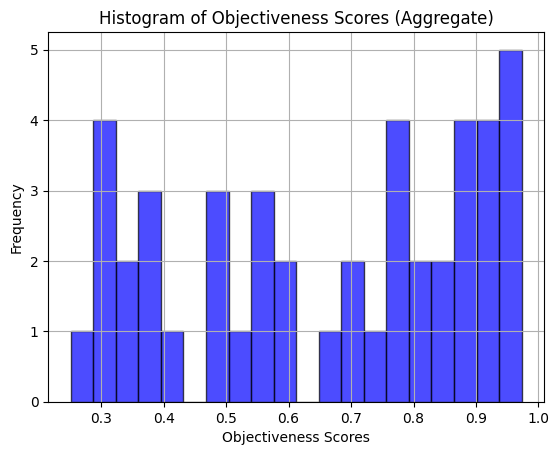

In [10]:
import os
import matplotlib.pyplot as plt

# Function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    objectiveness_scores = []
    for line in yolo_lines:
        # Split the line by spaces and take the 6th value (objectiveness score)
        objectiveness_score = float(line.split()[5])
        objectiveness_scores.append(objectiveness_score)
    return objectiveness_scores

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for objectiveness scores
all_objectiveness_scores = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations
        objectiveness_scores = parse_annotations(yolo_lines)

        # Accumulate objectiveness scores
        all_objectiveness_scores.extend(objectiveness_scores)

# Plot histogram for all objectiveness scores
plt.hist(all_objectiveness_scores, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Objectiveness Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Objectiveness Scores (Aggregate)')
plt.grid(True)
plt.show()


# Histogram of FPs

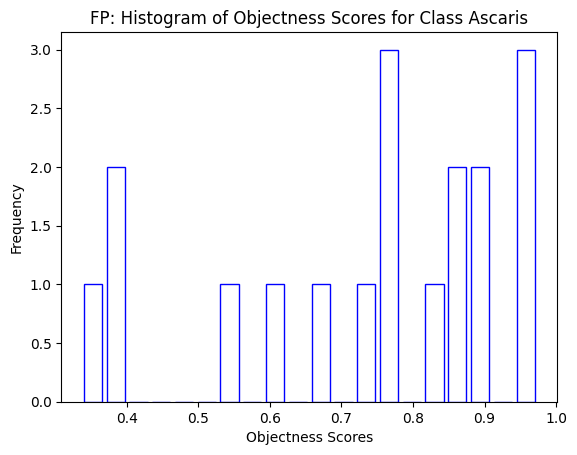

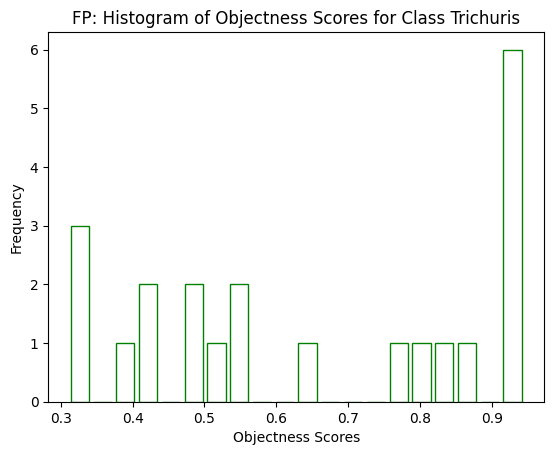

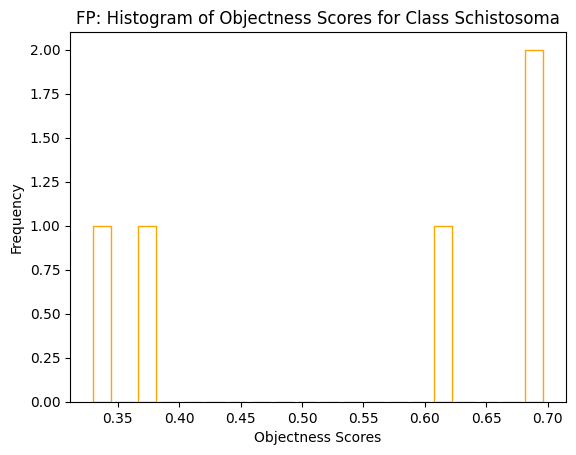

In [99]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Define classes and corresponding colors
classes = ['Ascaris', 'Trichuris', 'Hookworm', 'Schistosoma']
colors = ['blue', 'green', 'orange', 'orange']

# Function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    object_classes = defaultdict(list)
    for line in yolo_lines:
        # Split the line by spaces
        values = line.split()
        # Extract object class and objectiveness score
        obj_class = values[0]
        objectiveness_score = float(values[6])
        # Append objectiveness score to corresponding object class list
        object_classes[obj_class].append(objectiveness_score)
    return object_classes

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Parse and accumulate objectiveness scores for each object class
object_classes_scores = defaultdict(list)

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations
        object_classes = parse_annotations(yolo_lines)

        # Accumulate objectiveness scores for each object class
        for obj_class, scores in object_classes.items():
            object_classes_scores[obj_class].extend(scores)

# Plot histograms for each object class
for i, (obj_class, scores) in enumerate(object_classes_scores.items()):
    plt.hist(scores, bins=20, color=colors[i], edgecolor=colors[i], facecolor='none', label=classes[int(obj_class)], rwidth=0.8)
    plt.xlabel('Objectness Scores')
    plt.ylabel('Frequency')
    plt.title(f'FP: Histogram of Objectness Scores for Class {classes[int(obj_class)]}')
    # plt.legend()
    plt.show()


# TP

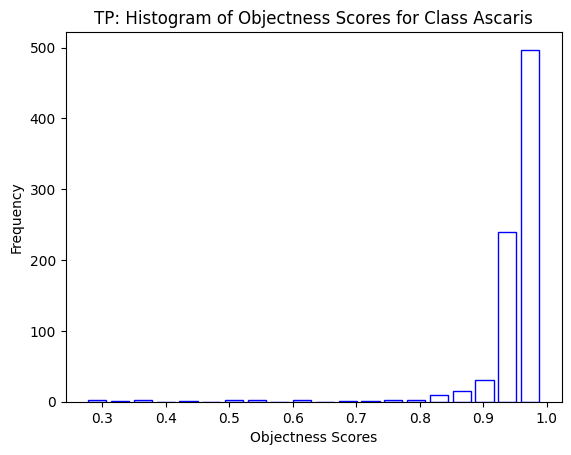

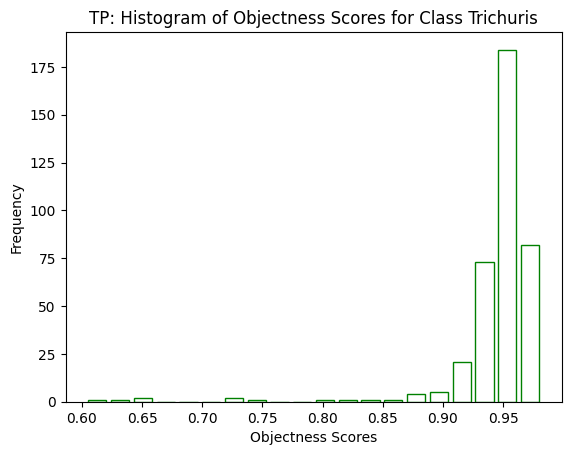

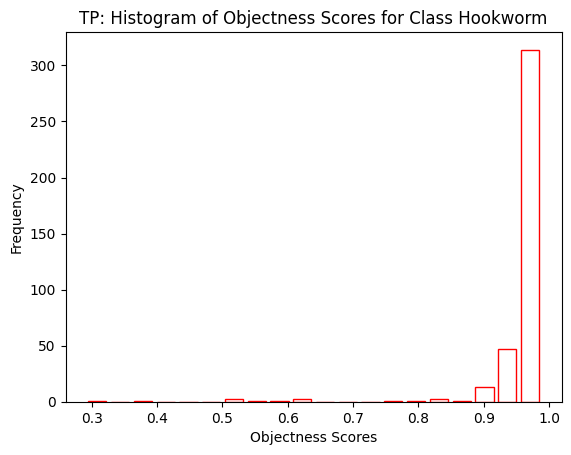

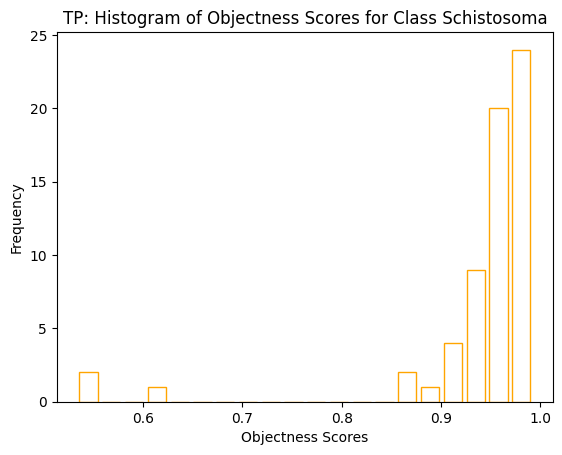

In [51]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Define classes and corresponding colors
classes = ['Ascaris', 'Trichuris', 'Hookworm', 'Schistosoma']
colors = ['blue', 'green', 'red', 'orange']

# Function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    object_classes = defaultdict(list)
    for line in yolo_lines:
        # Split the line by spaces
        values = line.split()
        # Extract object class and objectiveness score
        obj_class = values[0]
        objectiveness_score = float(values[6])
        # Append objectiveness score to corresponding object class list
        object_classes[obj_class].append(objectiveness_score)
    return object_classes

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Parse and accumulate objectiveness scores for each object class
object_classes_scores = defaultdict(list)

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations
        object_classes = parse_annotations(yolo_lines)

        # Accumulate objectiveness scores for each object class
        for obj_class, scores in object_classes.items():
            object_classes_scores[obj_class].extend(scores)

# Plot histograms for each object class
for i, (obj_class, scores) in enumerate(object_classes_scores.items()):
    plt.hist(scores, bins=20, color=colors[i], edgecolor=colors[i], facecolor='none', label=classes[int(obj_class)], rwidth=0.8)
    plt.xlabel('Objectness Scores')
    plt.ylabel('Frequency')
    plt.title(f'TP: Histogram of Objectness Scores for Class {classes[int(obj_class)]}')
    # plt.legend()
    plt.show()


# Class Probabilities


## FP

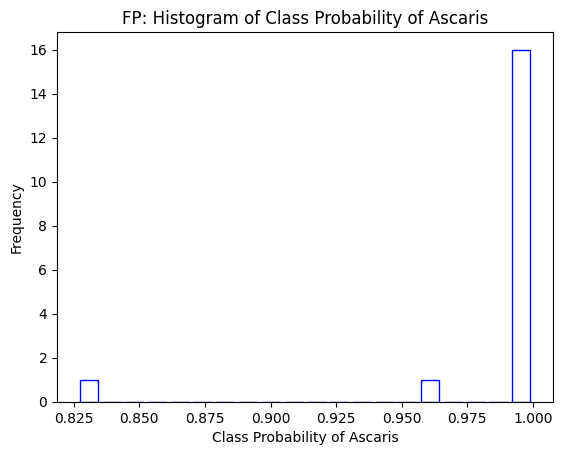

In [85]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 0:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[7])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='blue', edgecolor='blue', facecolor='none',alpha=1,rwidth=0.8)
plt.xlabel('Class Probability of Ascaris')
plt.ylabel('Frequency')
plt.title('FP: Histogram of Class Probability of Ascaris')
# plt.grid(True)
plt.show()


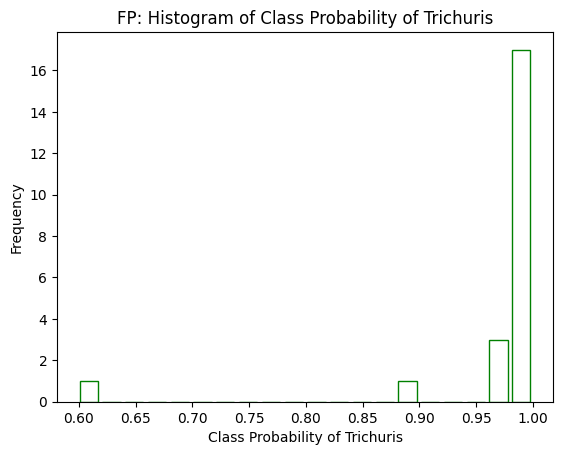

In [90]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 1:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[8])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='green', edgecolor='green', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Probability of Trichuris')
plt.ylabel('Frequency')
plt.title('FP: Histogram of Class Probability of Trichuris')
# plt.grid(True)
plt.show()


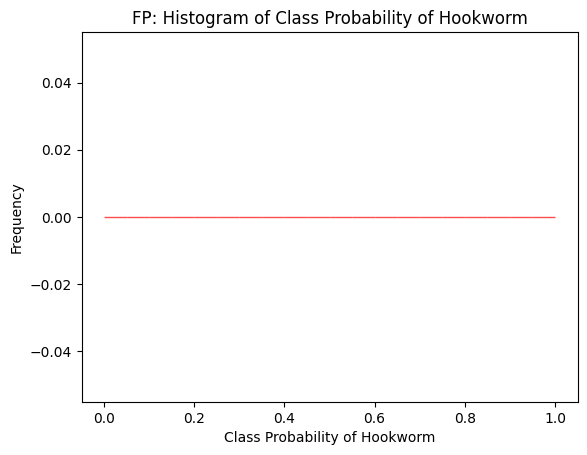

In [72]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 2:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[9])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='red', edgecolor='red', facecolor='none',alpha=0.7)
plt.xlabel('Class Probability of Hookworm')
plt.ylabel('Frequency')
plt.title('FP: Histogram of Class Probability of Hookworm')
# plt.grid(True)
plt.show()


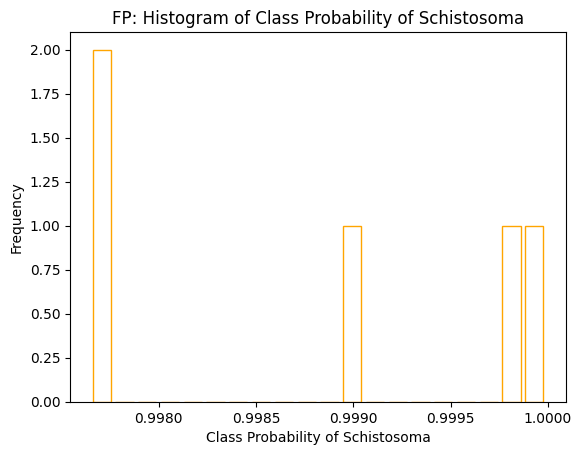

In [101]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 3:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[10])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='orange', edgecolor='orange', facecolor='none',alpha=1,rwidth=0.8)
plt.xlabel('Class Probability of Schistosoma')
plt.ylabel('Frequency')
plt.title('FP: Histogram of Class Probability of Schistosoma')
# plt.grid(True)
plt.show()


## TP

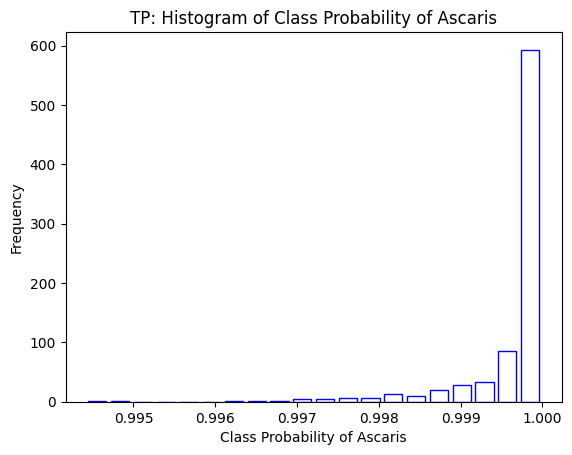

In [89]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 0:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[7])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='blue', edgecolor='blue', facecolor='none', rwidth=0.8)
plt.xlabel('Class Probability of Ascaris')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Probability of Ascaris')
# plt.grid(True)
plt.show()


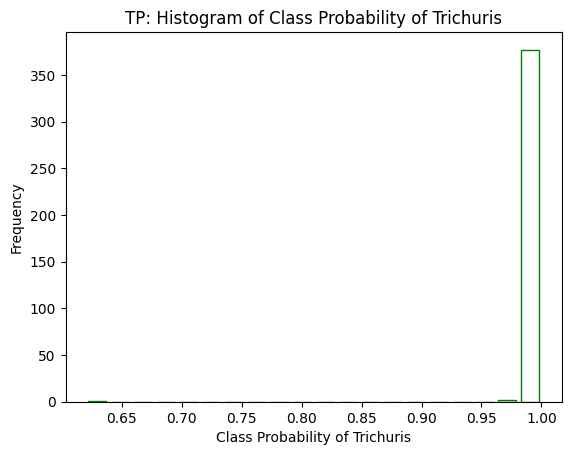

In [93]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 1:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[8])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='green', edgecolor='green', facecolor='none',alpha=1,rwidth=0.8)
plt.xlabel('Class Probability of Trichuris')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Probability of Trichuris')
# plt.grid(True)
plt.show()


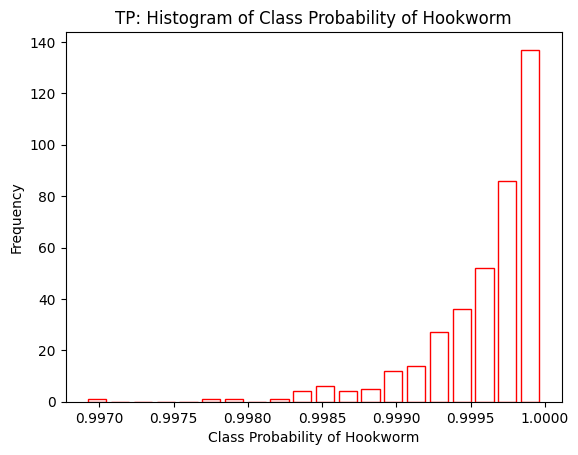

In [97]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 2:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[9])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='red', edgecolor='red', facecolor='none',alpha=1,rwidth=.8)
plt.xlabel('Class Probability of Hookworm')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Probability of Hookworm')
# plt.grid(True)
plt.show()


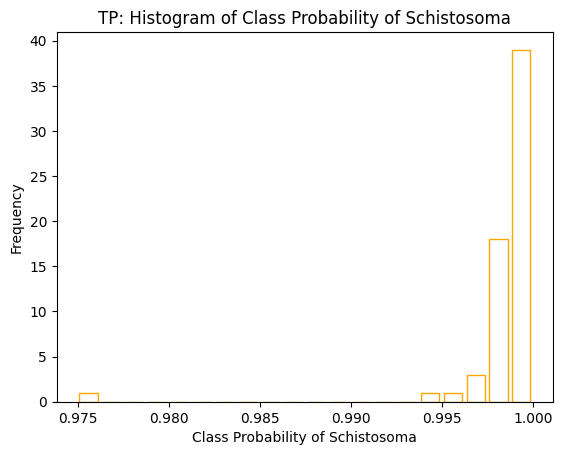

In [100]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 3:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[10])  # Index 7 is the Ascaris score
            objectness_score = float(values[6])  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='orange', edgecolor='orange', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Probability of Schistosoma')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Probability of Schistosoma')
# plt.grid(True)
plt.show()


# Class Scores

# FP

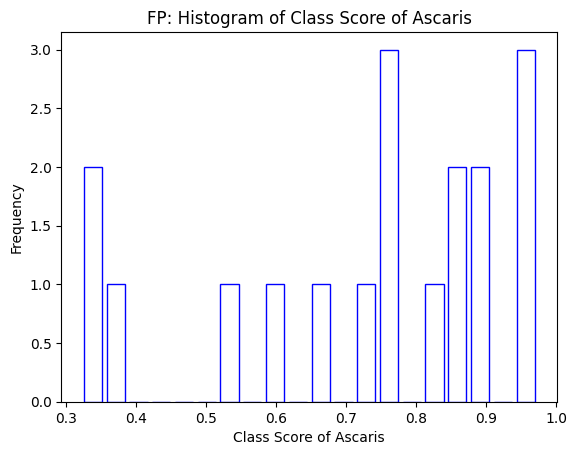

In [86]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 0:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[7])  # Index 7 is the Ascaris score
            objectness_score = 1  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='blue', edgecolor='blue', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Score of Ascaris')
plt.ylabel('Frequency')
plt.title('FP: Histogram of Class Score of Ascaris')
# plt.grid(True)
plt.show()


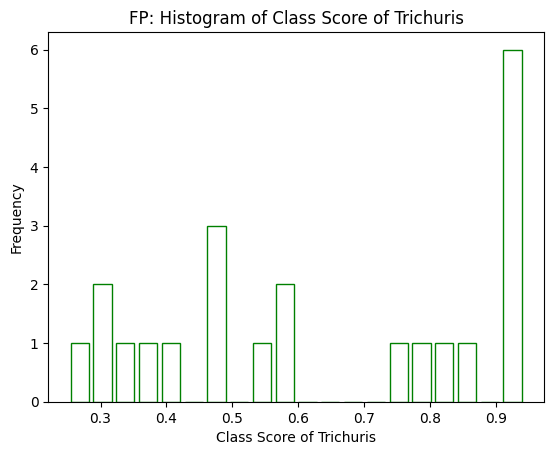

In [96]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 1:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[8])  # Index 7 is the Ascaris score
            objectness_score = 1  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='green', edgecolor='green', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Score of Trichuris')
plt.ylabel('Frequency')
plt.title('FP: Histogram of Class Score of Trichuris')
# plt.grid(True)
plt.show()


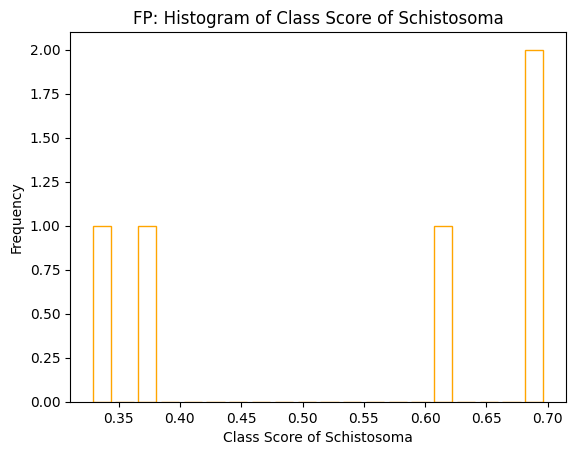

In [102]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 3:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[10])  # Index 7 is the Ascaris score
            objectness_score = 1  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\fp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='orange', edgecolor='orange', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Score of Schistosoma')
plt.ylabel('Frequency')
plt.title('FP: Histogram of Class Score of Schistosoma')
# plt.grid(True)
plt.show()


## TP

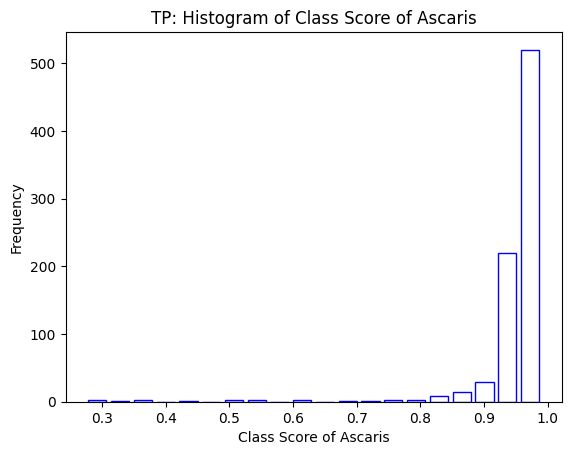

In [88]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 0:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[7])  # Index 7 is the Ascaris score
            objectness_score = 1  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='blue', edgecolor='blue', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Score of Ascaris')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Score of Ascaris')
# plt.grid(True)
plt.show()


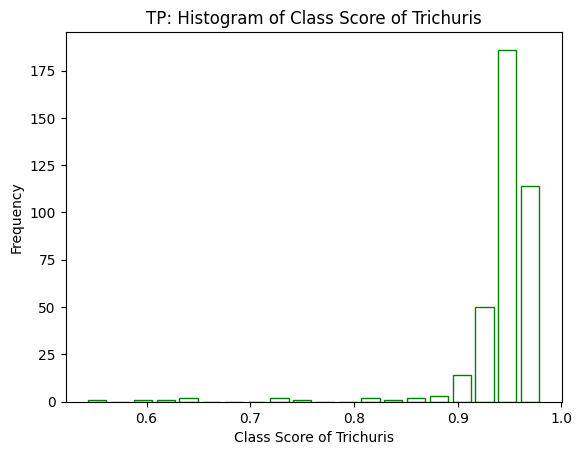

In [95]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 1:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[8])  # Index 7 is the Ascaris score
            objectness_score = 1  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='green', edgecolor='green', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Score of Trichuris')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Score of Trichuris')
# plt.grid(True)
plt.show()


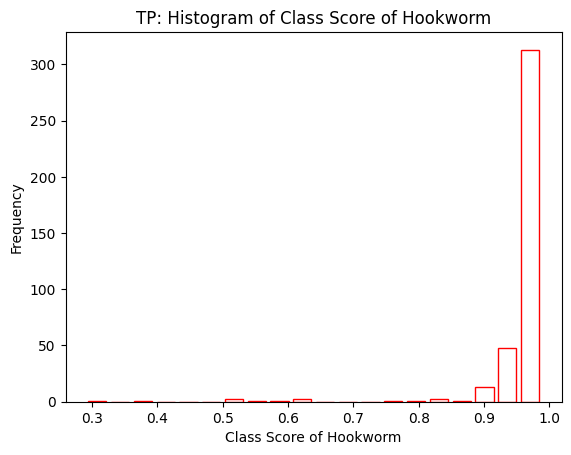

In [98]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 2:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[9])  # Index 7 is the Ascaris score
            objectness_score = 1  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='red', edgecolor='red', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Score of Hookworm')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Score of Hookworm')
# plt.grid(True)
plt.show()


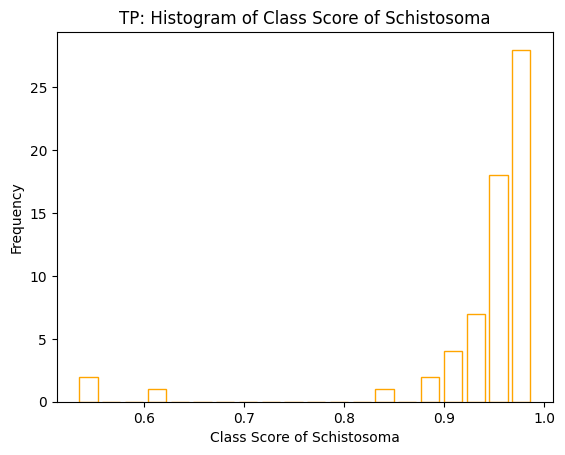

In [103]:
import os
import matplotlib.pyplot as plt

# Define function to parse annotations from YOLO prediction lines
def parse_annotations(yolo_lines):
    ascaris_probabilities = []
    for line in yolo_lines:
        values = line.split()
        object_id = int(values[0])  # Index 0 is the object ID
        if object_id == 3:  # Check if the object ID is 0 (Ascaris)
            ascaris_score = float(values[10])  # Index 7 is the Ascaris score
            objectness_score = 1  # Index 6 is the objectness score
            # Calculate class probability of Ascaris
            if objectness_score != 0:  # Avoid division by zero
                ascaris_probability = ascaris_score / objectness_score
                ascaris_probabilities.append(ascaris_probability)
    return ascaris_probabilities

# Directory containing YOLO prediction files
directory = r'C:\Users\M\OneDrive - UGent\TWML\yolov7\conformal_prediction\tp'

# Accumulator for Ascaris class probabilities
all_ascaris_probabilities = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Read YOLO prediction file
        with open(os.path.join(directory, filename), 'r') as file:
            yolo_lines = file.readlines()

        # Parse annotations and calculate Ascaris class probabilities
        ascaris_probabilities = parse_annotations(yolo_lines)

        # Accumulate Ascaris class probabilities
        all_ascaris_probabilities.extend(ascaris_probabilities)

# Plot histogram of Ascaris class probabilities
plt.hist(all_ascaris_probabilities, bins=20, color='orange', edgecolor='orange', facecolor='none',alpha=1, rwidth=0.8)
plt.xlabel('Class Score of Schistosoma')
plt.ylabel('Frequency')
plt.title('TP: Histogram of Class Score of Schistosoma')
# plt.grid(True)
plt.show()


# Detail Analysis 

In [105]:
import os

def truncate_yolo_annotations(yolo_annotations_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for file_name in os.listdir(yolo_annotations_directory):
        if file_name.endswith(".txt"):
            with open(os.path.join(yolo_annotations_directory, file_name), 'r') as file:
                lines = file.readlines()

            truncated_lines = []
            for line in lines:
                line_data = line.strip().split()
                truncated_line = " ".join(line_data[:6]) + "\n"  # Keep only the first 6 elements
                truncated_lines.append(truncated_line)

            with open(os.path.join(output_directory, file_name), 'w') as file:
                file.writelines(truncated_lines)

if __name__ == "__main__":
    yolo_annotations_directory = "conformal_prediction/fp"
    output_directory = "conformal_prediction/fp_coppied"

    truncate_yolo_annotations(yolo_annotations_directory, output_directory)